# CIFAR Vectorized RMIA Example

This notebook mirrors `cifar_main.ipynb` but configures the RMIA attack to use the vectorized fast path.

In [ ]:
# import os
# import sys
# import yaml

# project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
# sys.path.insert(0, project_root)


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [1]:
import os
import sys
import yaml
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)
    
root = train_config["data"]["data_dir"]
path = os.path.join(os.getcwd(), root)
# Load the CIFAR train and test datasets
if train_config["data"]["dataset"] == "cifar10":
    trainset = CIFAR10(root=root, train=True, download=True)
    testset = CIFAR10(root=root, train=False, download=True)
elif train_config["data"]["dataset"] == "cifar100":
    trainset = CIFAR100(root=root, train=True, download=True)
    testset = CIFAR100(root=root, train=False, download=True)
else:
    raise ValueError("Unknown dataset type")

train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255

# Ensure train and test data looks correct
assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
assert train_data.shape[1] == 3, "Data should have 3 channels"
assert test_data.shape[1] == 3, "Data should have 3 channels"
assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"

# Concatenate train and test data into the population
data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
# Create UserDataset object
population_dataset = CifarInputHandler.UserDataset(data, targets)

assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"

# Store the population dataset to be used by LeakPro
dataset_name = train_config["data"]["dataset"]
file_path =  "data/"+ dataset_name + ".pkl"
if not os.path.exists(file_path):
    with open(file_path, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {file_path}")


With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size)
test_size = int(test_fraction * dataset_size)

selected_index = np.random.choice(np.arange(dataset_size), train_size + test_size, replace=False)
train_indices, test_indices = train_test_split(selected_index, test_size=test_size)

train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)

# Evaluate mean and variance of the train data
train_mean = train_subset.mean
train_std = train_subset.std
print (f"Train mean: {train_mean}, Train std: {train_std}")

Train mean: tensor([[[0.4932]],

        [[0.4839]],

        [[0.4484]]]), Train std: tensor([[[0.2468]],

        [[0.2433]],

        [[0.2620]]])



With the train and test dataloader in place, we train a ResNet18. 
After training, we call LeakPro to create metadata that will be used during auditing.

In [3]:
from torch import save, optim, nn
from cifar_handler import CifarInputHandler
from target_model_class import ResNet18, WideResNet

# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

# Create instance of target model
#model = ResNet18(num_classes = num_classes)
model =  WideResNet(depth=28, num_classes=num_classes, widen_factor=2)

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
weight_decay = train_config["train"]["weight_decay"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# train target model
train_result = CifarInputHandler().train(dataloader=train_loader,
                            model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            epochs=epochs)

# Evaluate on test set
test_result = CifarInputHandler().eval(test_loader, model, criterion)

# Store the model and metadata
model = train_result.model
model.to("cpu")
with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                      optimizer = optimizer,
                                      loss_fn = criterion,
                                      dataloader = train_loader,
                                      test_result = test_result,
                                      epochs = epochs,
                                      train_indices = train_indices,
                                      test_indices = test_indices,
                                      dataset_name = dataset_name)

with open("target/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)
    

Epoch 1/25: 100%|██████████| 106/106 [00:12<00:00,  8.81it/s, acc=0.1861, loss=2.2857]


Validation loss at epoch 1: 2.1455


Epoch 2/25: 100%|██████████| 106/106 [00:11<00:00,  9.04it/s, acc=0.2845, loss=1.8571]


Validation loss at epoch 2: 2.0074


Epoch 3/25: 100%|██████████| 106/106 [00:11<00:00,  9.06it/s, acc=0.3338, loss=1.7384]


Validation loss at epoch 3: 2.6027


Epoch 4/25: 100%|██████████| 106/106 [00:11<00:00,  9.00it/s, acc=0.3588, loss=1.6719]


Validation loss at epoch 4: 2.2926


Epoch 5/25: 100%|██████████| 106/106 [00:11<00:00,  9.03it/s, acc=0.3995, loss=1.5876]


Validation loss at epoch 5: 2.3363


Epoch 6/25: 100%|██████████| 106/106 [00:11<00:00,  9.02it/s, acc=0.4387, loss=1.4999]


Validation loss at epoch 6: 4.4708


Epoch 7/25: 100%|██████████| 106/106 [00:11<00:00,  9.01it/s, acc=0.4605, loss=1.4492]


Validation loss at epoch 7: 2.3571


Epoch 8/25: 100%|██████████| 106/106 [00:24<00:00,  4.38it/s, acc=0.4675, loss=1.4337]


Validation loss at epoch 8: 1.8643


Epoch 9/25: 100%|██████████| 106/106 [00:23<00:00,  4.58it/s, acc=0.4848, loss=1.3917]


Validation loss at epoch 9: 2.0979


Epoch 10/25: 100%|██████████| 106/106 [00:23<00:00,  4.56it/s, acc=0.4911, loss=1.3731]


Validation loss at epoch 10: 2.0744


Epoch 11/25: 100%|██████████| 106/106 [00:23<00:00,  4.52it/s, acc=0.5110, loss=1.3313]


Validation loss at epoch 11: 2.4388


Epoch 12/25: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s, acc=0.5131, loss=1.3310]


Validation loss at epoch 12: 2.9566


Epoch 13/25: 100%|██████████| 106/106 [00:24<00:00,  4.34it/s, acc=0.5194, loss=1.3095]


Validation loss at epoch 13: 1.9689


Epoch 14/25: 100%|██████████| 106/106 [00:24<00:00,  4.35it/s, acc=0.5301, loss=1.2814]


Validation loss at epoch 14: 2.4161


Epoch 15/25: 100%|██████████| 106/106 [00:24<00:00,  4.35it/s, acc=0.5367, loss=1.2624]


Validation loss at epoch 15: 1.5164


Epoch 16/25: 100%|██████████| 106/106 [00:24<00:00,  4.37it/s, acc=0.5427, loss=1.2497]


Validation loss at epoch 16: 1.7068


Epoch 17/25: 100%|██████████| 106/106 [00:23<00:00,  4.58it/s, acc=0.5541, loss=1.2186]


Validation loss at epoch 17: 1.5159


Epoch 18/25: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s, acc=0.5641, loss=1.1952]


Validation loss at epoch 18: 1.5671


Epoch 19/25: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s, acc=0.5703, loss=1.1760]


Validation loss at epoch 19: 2.3641


Epoch 20/25: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s, acc=0.5793, loss=1.1493]


Validation loss at epoch 20: 1.3220


Epoch 21/25: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s, acc=0.5900, loss=1.1285]


Validation loss at epoch 21: 1.4051


Epoch 22/25: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s, acc=0.5969, loss=1.1065]


Validation loss at epoch 22: 1.1979


Epoch 23/25: 100%|██████████| 106/106 [00:23<00:00,  4.51it/s, acc=0.6053, loss=1.0815]


Validation loss at epoch 23: 1.1321


Epoch 24/25: 100%|██████████| 106/106 [00:23<00:00,  4.54it/s, acc=0.6125, loss=1.0640]


Validation loss at epoch 24: 1.1197


Epoch 25/25: 100%|██████████| 106/106 [00:23<00:00,  4.50it/s, acc=0.6173, loss=1.0524]


Validation loss at epoch 25: 1.1115


Plot accuracy and test of training and test.

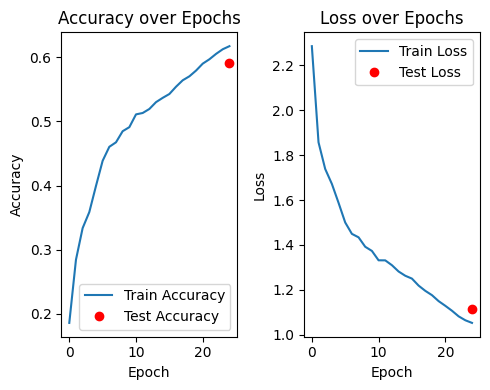

In [4]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Privacy Auditing with Vectorized RMIA

1. Create a LeakPro instance using the CIFAR input handler.
2. Clone `audit.yaml`, set `vectorized=True` for RMIA (and keep other attacks unchanged).
3. Run the audit and collect the results.


In [5]:
import copy
import yaml

config_path = "audit.yaml"
from leakpro import LeakPro
from cifar_handler import CifarInputHandler

with open(config_path, "r") as f:
    audit_config = yaml.safe_load(f)

vectorized_config = copy.deepcopy(audit_config)
attack_section = vectorized_config['audit'].get('attack_list', [])
attack_map = {}
if isinstance(attack_section, list):
    for entry in attack_section:
        name = entry.get('attack')
        params = {k: v for k, v in entry.items() if k != 'attack'}
        attack_map[name] = params
elif isinstance(attack_section, dict):
    attack_map = copy.deepcopy(attack_section)
else:
    raise ValueError('Unsupported attack_list structure')

rmia_cfg = attack_map.get('rmia', {}) or {}
rmia_cfg['vectorized'] = True
rmia_cfg.setdefault('vec_batch_points', 1024)
rmia_cfg.setdefault('vec_use_all_z', False)
rmia_cfg.setdefault('vec_z_chunk', 2048)
attack_map['rmia'] = rmia_cfg

attack_list = []
for name, params in attack_map.items():
    if name is None:
        continue
    entry = {'attack': name}
    if params is not None:
        entry.update(params)
    attack_list.append(entry)
vectorized_config['audit']['attack_list'] = attack_list

vectorized_config_path = "audit_vectorized.yaml"
with open(vectorized_config_path, 'w') as f:
    yaml.safe_dump(vectorized_config, f, sort_keys=False)

# Instantiate LeakPro with the vectorized RMIA configuration
leakpro = LeakPro(CifarInputHandler, vectorized_config_path)

# Run the audit
mia_results = leakpro.run_audit(create_pdf=True)


2025-10-30 14:53:21,850 INFO     Target model blueprint created from WideResNet in ./target_model_class.py.
10/30/2025 14:53:21:INFO:Target model blueprint created from WideResNet in ./target_model_class.py.
2025-10-30 14:53:21,914 INFO     Loaded target model metadata from ./target/model_metadata.pkl
10/30/2025 14:53:21:INFO:Loaded target model metadata from ./target/model_metadata.pkl
2025-10-30 14:53:21,989 INFO     Loaded target model from ./target
10/30/2025 14:53:21:INFO:Loaded target model from ./target
2025-10-30 14:53:23,250 INFO     Loaded population dataset from ./data/cifar10.pkl
10/30/2025 14:53:23:INFO:Loaded population dataset from ./data/cifar10.pkl
2025-10-30 14:53:27.816088: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 14:53:27.880037: I te

<Figure size 640x480 with 0 Axes>

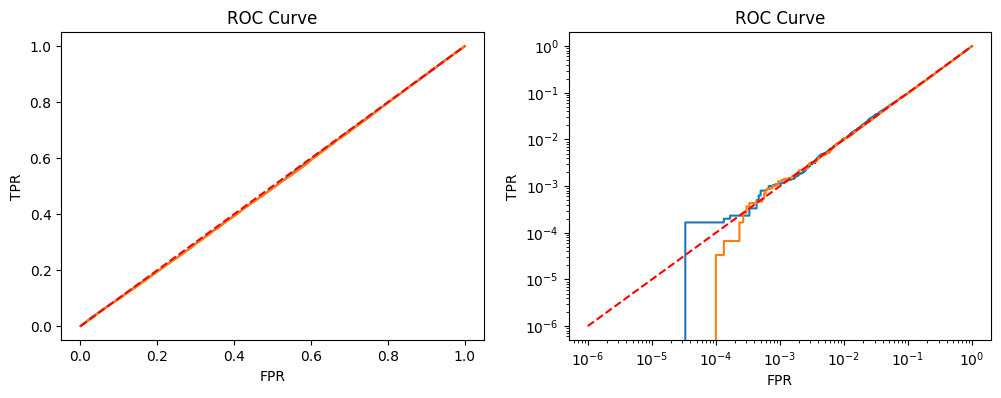

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr, tpr) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr, tpr, smart, label=label)
            else:
                ax.loglog(fpr, tpr, smart, label=label)
        if results:
            diag = np.linspace(1e-6 if not flag else 0.0, 1.0, 200)
            ax.plot(diag, diag, 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
    plt.show()

mia_roc_curves = []
labels = []
for result in mia_results:
    fpr = getattr(result, 'fpr', None)
    tpr = getattr(result, 'tpr', None)
    if fpr is None or tpr is None:
        continue
    mia_roc_curves.append((fpr, tpr))
    labels.append(result.result_name)

if mia_roc_curves:
    plot_results(mia_roc_curves, labels=labels)
else:
    print('No ROC curves available to plot.')


### Reusing Cached Logits

If you already trained the target and shadow models and cached their logits plus the membership mask, you can load them and feed them straight into `vectorized_rmia_score`. The next cell demonstrates both the load-from-disk path and a synthetic fallback so you can exercise the code even when the cached files are absent.


In [ ]:
from pathlib import Path
import numpy as np

from leakpro.attacks.mia_attacks.rmia import vectorized_rmia_score

shadow_path = Path("shadow_logits.npy")
inmask_path = Path("shadow_inmask.npy")
target_path = Path("target_logits.npy")

if shadow_path.exists() and inmask_path.exists() and target_path.exists():
    print("Loading cached logits and membership mask...")
    shadow_logits = np.load(shadow_path)
    shadow_inmask = np.load(inmask_path).astype(bool)
    target_logits = np.load(target_path)
else:   ### thid is for smoke test only, just a toy example 
    print("Cached files not found; generating synthetic logits for a smoke test.")
    rng = np.random.default_rng(42)
    N, M = 256, 8  # number of audit samples (N) and shadow models (M)
    shadow_logits = rng.normal(size=(N, M))
    target_logits = rng.normal(size=N)
    shadow_inmask = rng.random((N, M)) < 0.5

scores = vectorized_rmia_score(
    shadow_logits=shadow_logits,
    shadow_inmask=shadow_inmask,
    target_logits=target_logits,
    z_sample_size=min(256, max(1, shadow_logits.shape[0] - 1)),
    gamma=1.0,
    use_all_z=False,
    batch_points=1024,
    offline_a=0.33,  # set to None if your setup is online
)

print(f'Computed RMIA scores for {scores.shape[0]} samples.')
print('First five scores:', scores[:5])

# Load or synthesize membership labels for ROC computation
target_inmask_path = Path('target_inmask.npy')
if target_inmask_path.exists():
    membership = np.load(target_inmask_path).astype(bool)
else:
    rng = np.random.default_rng(123)
    membership = rng.random(scores.shape[0]) < 0.5

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(membership.astype(int), scores)
plot_results([(fpr, tpr)], labels=['Vectorized RMIA (cached)'])
